# Bangalore House Price Prediction - Accuracy Evaluation
This notebook trains a Decision Tree Regressor on the Bangalore dataset and prints out evaluation metrics such as R², MAE, RMSE, and MAPE.


 Before tuning R²: 0.99

 Final R² Score: 0.99
 MAE: 156925.15
 RMSE: 582150.95
 Accuracy Percentage: 99.0 %

 Saved as: bangalore_data_final1.csv


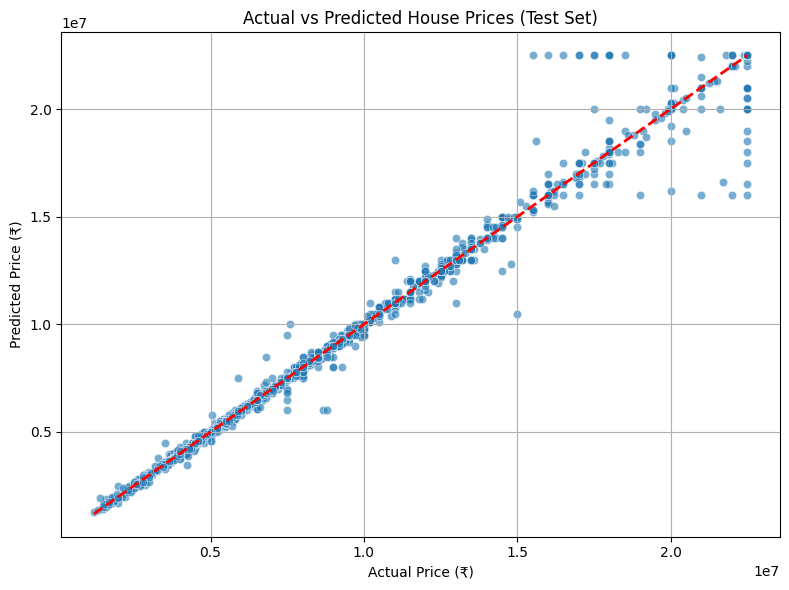

 Plot saved as: actual_vs_predicted.png


In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("bangalore_data_final.csv")

# Drop unnamed and duplicate columns
df = df.drop(columns=[col for col in df.columns if col.lower().startswith("unnamed")])
df = df.drop_duplicates()

# Clean data
df["total_sqft"] = pd.to_numeric(df["total_sqft"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["total_sqft", "bath", "balcony", "BHK", "area_type", "price"])

# Outlier removal
df = df[df['bath'] <= df['BHK'] + 2]
df = df[df['total_sqft'] / df['BHK'] >= 300]

# Encode categorical
le = LabelEncoder()
df["area_type"] = le.fit_transform(df["area_type"].astype(str))

# Features and target
X = df.drop("price", axis=1)
y = df["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train initial model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
r2_before = r2_score(y_test, y_pred)
print(" Before tuning R²:", round(r2_before, 4))

# Hyperparameter tuning
if r2_before < 0.90:
    print("\n Tuning hyperparameters...")
    param_grid = {
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
else:
    best_model = dt

# Final evaluation
y_pred_best = best_model.predict(X_test_scaled)
r2_final = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("\n Final R² Score:", round(r2_final, 4))
print(" MAE:", round(mae, 2))
print(" RMSE:", round(rmse, 2))
print(" Accuracy Percentage:", round(r2_final * 100, 2), "%")

# Save results to CSV
output = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred_best
})
output.to_csv("bangalore_data_final1.csv", index=False)
print("\n Saved as: bangalore_data_final1.csv")

# Save Actual vs Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=output["Actual Price"], y=output["Predicted Price"], alpha=0.6)
plt.plot([output["Actual Price"].min(), output["Actual Price"].max()],
         [output["Actual Price"].min(), output["Actual Price"].max()],
         'r--', lw=2)
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.title("Actual vs Predicted House Prices (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()
print(" Plot saved as: actual_vs_predicted.png")
